# CIFAR10 Transfer Learning based Classifier

This notebook outlines the steps to build a classifier to leverage concepts of Transfer Learning by utilizing a pretrained Deep-CNN. 
Particularly in this case based on VGG16

In [1]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [8]:
import tensorflow as tf
import keras
import numpy as np
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [10]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [13]:
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

In [15]:
from PIL import Image

X_train = np.array([Image.fromarray(x).resize((48,48)) for x in X_train])

X_val = np.array([Image.fromarray(x).resize((48,48)) for x in X_val])

X_test = np.array([Image.fromarray(x).resize((48,48)) for x in X_test])


In [16]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [17]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [19]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(base_model.input, pred)

In [20]:
for layer in base_model.layers:
     layer.trainable = False

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,870,666 (7.14 MB)

 Trainable params: 134,666 (526.04 KB)

 Non-trainable params: 1,736,000 (6.62 MB)

In [24]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [25]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [26]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

In [30]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=EPOCHS,
                    verbose=1)


Epoch 1/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 169s 127ms/step - accuracy: 0.4555 - loss: 0.2495 - val_accuracy: 0.6242 - val_loss: 0.1822
Epoch 2/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 101us/step - accuracy: 0.5312 - loss: 0.1254 - val_accuracy: 0.6667 - val_loss: 0.0813
Epoch 3/40
   1/1328 ━━━━━━━━━━━━━━━━━━━━ 2:54 132ms/step - accuracy: 0.5938 - loss: 0.1916

2024-03-15 11:36:01.287493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 11:36:01.398441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 181s 137ms/step - accuracy: 0.5749 - loss: 0.2040 - val_accuracy: 0.6633 - val_loss: 0.1632
Epoch 4/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 67us/step - accuracy: 0.5000 - loss: 0.1071 - val_accuracy: 0.5833 - val_loss: 0.0804
Epoch 5/40


2024-03-15 11:39:02.833618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 11:39:02.903620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 186s 140ms/step - accuracy: 0.6240 - loss: 0.1833 - val_accuracy: 0.6858 - val_loss: 0.1525
Epoch 6/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.5938 - loss: 0.0799 - val_accuracy: 0.8333 - val_loss: 0.0532
Epoch 7/40


2024-03-15 11:42:09.323055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 11:42:09.384287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 190s 143ms/step - accuracy: 0.6487 - loss: 0.1698 - val_accuracy: 0.7013 - val_loss: 0.1449
Epoch 8/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 67us/step - accuracy: 0.6875 - loss: 0.0883 - val_accuracy: 0.5000 - val_loss: 0.1136
Epoch 9/40


2024-03-15 11:45:19.210714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 11:45:19.279124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 197s 148ms/step - accuracy: 0.6740 - loss: 0.1603 - val_accuracy: 0.7066 - val_loss: 0.1400
Epoch 10/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - accuracy: 0.7500 - loss: 0.0692 - val_accuracy: 0.6667 - val_loss: 0.0785
Epoch 11/40


2024-03-15 11:48:35.951766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 11:48:36.011824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 194s 146ms/step - accuracy: 0.6878 - loss: 0.1549 - val_accuracy: 0.7183 - val_loss: 0.1358
Epoch 12/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.6250 - loss: 0.0918 - val_accuracy: 0.8333 - val_loss: 0.0784
Epoch 13/40


2024-03-15 11:51:49.760734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 11:51:49.819575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 191s 144ms/step - accuracy: 0.6924 - loss: 0.1507 - val_accuracy: 0.7265 - val_loss: 0.1321
Epoch 14/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 59us/step - accuracy: 0.6250 - loss: 0.0891 - val_accuracy: 0.9167 - val_loss: 0.0484
Epoch 15/40


2024-03-15 11:55:01.146418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 11:55:01.204093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 193s 145ms/step - accuracy: 0.7078 - loss: 0.1443 - val_accuracy: 0.7281 - val_loss: 0.1303
Epoch 16/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 59us/step - accuracy: 0.7500 - loss: 0.0669 - val_accuracy: 0.5000 - val_loss: 0.0846
Epoch 17/40


2024-03-15 11:58:14.114555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 11:58:14.171534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 193s 146ms/step - accuracy: 0.7143 - loss: 0.1418 - val_accuracy: 0.7350 - val_loss: 0.1276
Epoch 18/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 59us/step - accuracy: 0.7188 - loss: 0.0564 - val_accuracy: 0.7500 - val_loss: 0.0443
Epoch 19/40


2024-03-15 12:01:27.555602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:01:27.613373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 193s 145ms/step - accuracy: 0.7221 - loss: 0.1381 - val_accuracy: 0.7365 - val_loss: 0.1252
Epoch 20/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 58us/step - accuracy: 0.6250 - loss: 0.0632 - val_accuracy: 0.8333 - val_loss: 0.0540
Epoch 21/40


2024-03-15 12:04:40.783067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:04:40.838554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 194s 146ms/step - accuracy: 0.7256 - loss: 0.1350 - val_accuracy: 0.7397 - val_loss: 0.1240
Epoch 22/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 63us/step - accuracy: 0.6875 - loss: 0.0687 - val_accuracy: 0.5000 - val_loss: 0.0958
Epoch 23/40


2024-03-15 12:07:54.611691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:07:54.672160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 193s 145ms/step - accuracy: 0.7312 - loss: 0.1326 - val_accuracy: 0.7481 - val_loss: 0.1225
Epoch 24/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - accuracy: 0.7812 - loss: 0.0579 - val_accuracy: 0.5833 - val_loss: 0.0649
Epoch 25/40


2024-03-15 12:11:07.630999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:11:07.690749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 195s 147ms/step - accuracy: 0.7350 - loss: 0.1312 - val_accuracy: 0.7439 - val_loss: 0.1216
Epoch 26/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.6562 - loss: 0.0885 - val_accuracy: 0.6667 - val_loss: 0.0750
Epoch 27/40


2024-03-15 12:14:22.604629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:14:22.661617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 201s 151ms/step - accuracy: 0.7379 - loss: 0.1297 - val_accuracy: 0.7505 - val_loss: 0.1202
Epoch 28/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 69us/step - accuracy: 0.6875 - loss: 0.0600 - val_accuracy: 0.6667 - val_loss: 0.0424
Epoch 29/40


2024-03-15 12:17:43.665112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:17:43.733952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 201s 151ms/step - accuracy: 0.7455 - loss: 0.1270 - val_accuracy: 0.7535 - val_loss: 0.1190
Epoch 30/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 65us/step - accuracy: 0.6875 - loss: 0.0539 - val_accuracy: 0.8333 - val_loss: 0.0416
Epoch 31/40


2024-03-15 12:21:04.491216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:21:04.553029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 197s 148ms/step - accuracy: 0.7538 - loss: 0.1231 - val_accuracy: 0.7496 - val_loss: 0.1185
Epoch 32/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 67us/step - accuracy: 0.7812 - loss: 0.0802 - val_accuracy: 0.9167 - val_loss: 0.0325
Epoch 33/40


2024-03-15 12:24:21.299950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:24:21.367672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 200s 150ms/step - accuracy: 0.7509 - loss: 0.1232 - val_accuracy: 0.7524 - val_loss: 0.1174
Epoch 34/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 64us/step - accuracy: 0.8750 - loss: 0.0559 - val_accuracy: 1.0000 - val_loss: 0.0421
Epoch 35/40


2024-03-15 12:27:41.131127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:27:41.193143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 194s 146ms/step - accuracy: 0.7533 - loss: 0.1226 - val_accuracy: 0.7581 - val_loss: 0.1164
Epoch 36/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - accuracy: 0.6250 - loss: 0.0725 - val_accuracy: 0.7500 - val_loss: 0.0505
Epoch 37/40


2024-03-15 12:30:55.697396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:30:55.755006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 205s 154ms/step - accuracy: 0.7602 - loss: 0.1201 - val_accuracy: 0.7580 - val_loss: 0.1157
Epoch 38/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 103us/step - accuracy: 0.8125 - loss: 0.0483 - val_accuracy: 0.5833 - val_loss: 0.1034
Epoch 39/40


2024-03-15 12:34:20.710203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:34:20.819401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 196s 147ms/step - accuracy: 0.7620 - loss: 0.1199 - val_accuracy: 0.7573 - val_loss: 0.1153
Epoch 40/40
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 66us/step - accuracy: 0.6875 - loss: 0.0771 - val_accuracy: 0.7500 - val_loss: 0.0619


2024-03-15 12:37:36.713553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-15 12:37:36.775152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


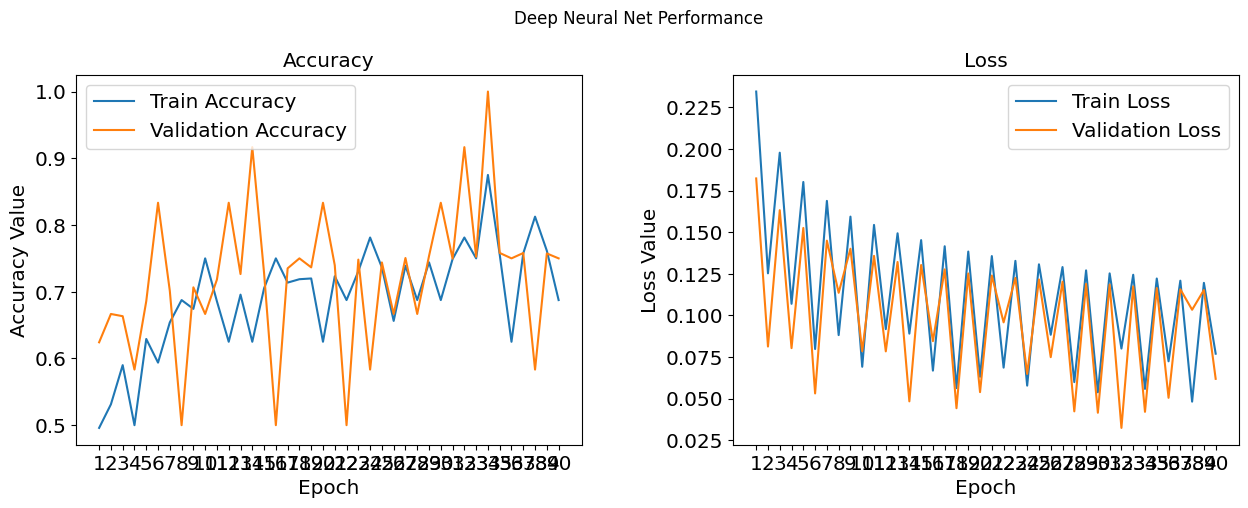

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [32]:
predictions = model.predict(X_test/255.)

313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step


In [33]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [34]:
get_metrics(true_labels=y_test, 
                predicted_labels=predictions)

Accuracy: 0.7601
Precision: 0.7585
Recall: 0.7601
F1 Score: 0.7585


In [35]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

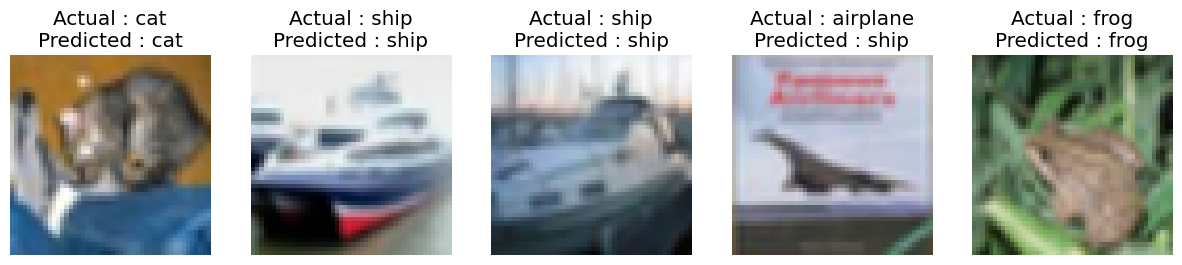

In [37]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))   
for i in range(5):
    ax[i].imshow(X_test[i])
    ax[i].set_title("Actual : {}\nPredicted : {}".format(label_dict[y_test[i][0]], label_dict[predictions[i]]))
    ax[i].axis('off')
plt.show()
